## Problem Statement

Reddit is a network of communities where users can share news content or comment on each other posting.
As there are over 1.5 million subreddits on reddit. Given that users can post on anything on any of the subreddits, Moderator will have difficulties to visually going into all posting to ensure that postings are  relevant to the respective subreddit. 
The objective of this project is to use machine learning to create a classification model  and see how well that can it distinguish the postings and re-classify the posts to the respective subreddit or remove it.  As such I picked two closely-related subreddits for the challenge.

## Data Collection

In [60]:
import requests
import numpy as np
import pandas as pd

import time
import string
import re

import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup    

# Import NLTK.
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # Import the stopword list
# Import train_test_split.
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score

### Data Scrapping

In [2]:
# #Function to scrap data from reddit 
# def pull_post(subreddit, size_of_pull):
    
#     posts_list = []
#     date = None
#     while len(posts_list) < size_of_pull:
#         url = 'https://api.pushshift.io/reddit/search/submission'
#         params = {
#             'subreddit' : subreddit,
#             'size' : 100,
#             'before' : date,
#         }
#         res = requests.get(url,params)
#         data = res.json()    
#         posts = data['data']
#         try:
#             date = posts[len(posts)-1]['created_utc']
#             posts_list.append(posts)
#             #print(date)
#             time.sleep(2)
#         except:
#             break

#     new_posts_list = []
#     for i in posts_list:
#         new_posts_list += i
#     subreddit_df = pd.DataFrame(new_posts_list)
#     return subreddit_df

#### Scrapping CryptoCurrency Posts

In [3]:
# call the scrap 1.

#commented the next two line becos it takes too long to scrap thus data already saved into csv prior to that
# crypto_c = pull_post('CryptoCurrency',100)
# crypto_c.to_csv(f'crypto_c.csv', index=False)
print('File Created!')

File Created!


#### Scrapping Bitcoin Posts

In [4]:
# call the scrap 2.

#commented the next two line becos it takes too long to scrap thus data already saved into csv prior to that
# bitcoin = pull_post('bitcoin',100)
# bitcoin.to_csv(f'bitcoin.csv', index=False)
print('File Created!')

File Created!


In [5]:
crypto_c = pd.read_csv('../datasets/crypto_c.csv')

In [6]:
bitcoin = pd.read_csv('../datasets/bitcoin.csv')

In [7]:
#see the shape of the table
print(crypto_c.shape)
print(bitcoin.shape)

(9955, 82)
(9998, 80)


In [67]:
crypto_c.head(2)

,selftext,subreddit,title
1,"Hi, I'm a young guy in his 20's and I think I ...",CryptoCurrency,"ARK is having a YT livestream w/ Elon, Jack, C..."
3,I have Coinbase but was fortunate enough to g...,CryptoCurrency,Legitmacy of Cirus Foundation


In [68]:
bitcoin.head(2)

,selftext,subreddit,title
4,I happen to be a crypto enthusiast and I've be...,Bitcoin,Feeling Bearish 🐻
6,YungSnxw’s\nCrypto Exchange Price’s\n\n100$ - ...,Bitcoin,anyone able to find the exact date of the sell...


## Data Cleaning

### Cleaning the two subreddits

Taking only the intersted columns from the scape, clean duplicate, drop those post that was removed by moderator

In [10]:
#function to clean the tables
def table_clean(table_lists):
    for table in table_lists:
        table.drop(table.columns.difference(['subreddit','selftext','title']),axis = 1, inplace = True)
        # Drop duplicate rows by comparing title
        table.drop_duplicates(subset='title', inplace=True)
        # Drop nan
        table.dropna(axis=0, how='any', inplace=True)
        # Drop post that was removed by the moderator
        table.drop(table[table.selftext == '[removed]'].index, inplace=True)
        table.drop(table[table.selftext == '[deleted]'].index, inplace=True)
        
        for index, post in enumerate(table.selftext): # for each index and posts 
            post_loop = post.replace('&amp;','&') # replace the weird entity
            post_loop = post_loop.replace('#x200B;',' ') # manually remove symbols identified
            table.selftext[index] = post_loop


In [11]:
tables = [crypto_c,bitcoin]
table_clean(tables)

In [12]:
print(crypto_c.shape)
print(bitcoin.shape)

(1672, 3)
(3178, 3)


### Combine the two tables

In [13]:
reddit = pd.concat([crypto_c, bitcoin], axis=0)

Reset the indexs

In [14]:
reddit.reset_index(drop = True,inplace = True)

In [15]:
# Coverting Subreddit into binary label
reddit['subreddit'] = reddit['subreddit'].map({'CryptoCurrency': 0, 'Bitcoin': 1})

In [16]:
reddit.head(-3)

,selftext,subreddit,title
0,"Hi, I'm a young guy in his 20's and I think I ...",0,"ARK is having a YT livestream w/ Elon, Jack, C..."
1,I have Coinbase but was fortunate enough to g...,0,Legitmacy of Cirus Foundation
2,my friend owes me money and has money in cryp...,0,Is it possible?
3,\nAre you bullish or bearish in the coming wee...,0,Best places to purchase BTC in the USA
4,**Welcome to the Daily General Discussion thre...,0,If I don’t buy Bitgert/BRISE tonight or tomorr...
...,...,...,...
4842,Is it important to diversify outside of crypto...,1,Contingency investments if btc fails
4843,"Wallet 967: \n\nToday, I stumbled upon a walle...",1,967 - Bitcoin Wallet
4844,"Hello, a little bit none crypto question, but ...",1,Relation Between CPI (inflation) and PPI...?
4845,Some people are saying bitcoin is a store of e...,1,Bitcoin as energy


### Cleaning the Post Texts

In [17]:
#function to clean the selftext
def post_to_words(raw_post):
    # Function to convert a raw review to a string of words
       
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove http
    post_text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', post_text)

    # 3. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 4. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 5. Remove punctuation and split 's, 't, 've with a space for filter
    post_text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', post_text)
    
    # 6. Remove whitespace (including new line characters)
    post_text = re.sub(r'\s\s+', ' ', post_text)
    
    # 7. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))

    
    # 8. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # 9. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [18]:
reddit['selftext'] = reddit['selftext'].apply(post_to_words)

C:\Users\CAdministrator\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://youtu.be/ygQ_YcF8Ww0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\CAdministrator\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://thenewscrypto.com/vladimir-putin-approves-bill-restricting-digital-financial-assets/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\CAdministrator\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://youtu.be/jsf0yYCMuRY" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the doc

## Pre-Processing

### Lemmatize

In [19]:
#combine similar forms of the same word
lemmatizer = WordNetLemmatizer()

def lemmatize_words(post_text):
    words = post_text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words    

In [20]:
reddit['selftext'] = reddit['selftext'].apply(lemmatize_words)

In [21]:
reddit.isnull().sum()

selftext     0
subreddit    0
title        0
dtype: int64

### Tokenize

#### CountVectorizer

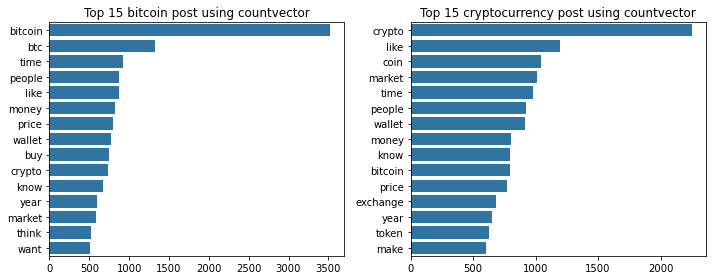

In [22]:
# To get the top 35 words from the entire df
# Bitcoin
cvec = CountVectorizer(stop_words = 'english', 
                       max_features = 35) 

# input for CountVectorizer is an array of strings
vector_text_bitcoin = reddit[reddit['subreddit'] == 1]['selftext']

# fit_transform the vectorizer
# convert training data to dataframe
bitcoin_words_df = pd.DataFrame(cvec.fit_transform
                               (vector_text_bitcoin).todense(), 
                               columns=cvec.get_feature_names())

# CryptoCurrency
# input for CountVectorizer is an array of strings
vector_text_cryptoc = reddit[reddit['subreddit'] == 0]['selftext']

# fit_transform the vectorizer
# convert training data to dataframe
cryptoc_words_df = pd.DataFrame(cvec.fit_transform
                               (vector_text_cryptoc).todense(), 
                               columns=cvec.get_feature_names())


#plot histograms 
fig = plt.figure(figsize=(10,4))

fig1 = fig.add_subplot(1,2,1);
sns.barplot(y= bitcoin_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).index,
            x= bitcoin_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).values,
            color='tab:blue')

fig2 = fig.add_subplot(1,2,2);
sns.barplot(y= cryptoc_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).index,
            x= cryptoc_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).values,
            color='tab:blue')

fig1.set_title('Top 15 bitcoin post using countvector')
fig2.set_title('Top 15 cryptocurrency post using countvector')

plt.tight_layout(); plt.show()

#### Tf-idf Vectorizer

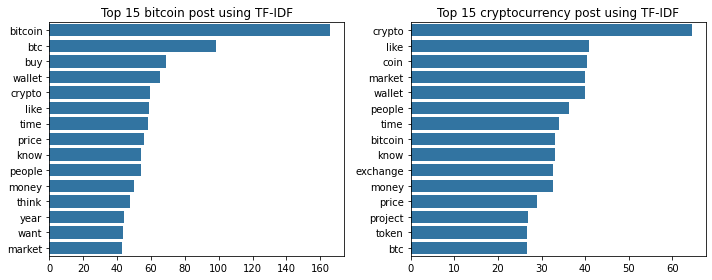

In [23]:
# Instantiate and fit the transformer.
# Bitcoin
tvec = TfidfVectorizer(analyzer = "word",
                       stop_words = "english",
                      )

# convert training data to dataframe
bitcoin_words_df = pd.DataFrame(tvec.fit_transform
                               (vector_text_bitcoin).todense(), 
                               columns=tvec.get_feature_names())
# CryptoCurrency
# convert training data to dataframe
cryptoc_words_df = pd.DataFrame(tvec.fit_transform
                               (vector_text_cryptoc).todense(), 
                               columns=tvec.get_feature_names())

#plot histograms 
fig = plt.figure(figsize=(10,4))

fig1 = fig.add_subplot(1,2,1);
sns.barplot(y= bitcoin_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).index,
            x= bitcoin_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).values,
            color='tab:blue')

fig2 = fig.add_subplot(1,2,2);
sns.barplot(y= cryptoc_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).index,
            x= cryptoc_words_df.sum
               ().sort_values(ascending=False
                             ).head(15).values,
            color='tab:blue')

fig1.set_title('Top 15 bitcoin post using TF-IDF')
fig2.set_title('Top 15 cryptocurrency post using TF-IDF')

plt.tight_layout(); plt.show()

In [24]:
print('Top 50 words in bitcoin subreddit using TF-IDF')
bitcoin_words_df.sum().sort_values(ascending=False).head(50)

Top 50 words in bitcoin subreddit using TF-IDF


bitcoin        165.859232
btc             98.422736
buy             68.973972
wallet          65.152706
crypto          59.165210
like            58.596560
time            58.148432
price           55.785110
know            54.208292
people          54.063464
money           50.193269
think           47.495111
year            44.222310
want            43.306934
market          42.986999
use             39.145696
exchange        38.685410
going           36.968885
coin            36.502409
way             35.311639
good            35.278838
make            33.893257
new             33.619257
say             31.881908
need            30.667058
day             30.451061
buying          30.238178
guy             29.822203
help            28.946329
value           28.874955
transaction     28.563708
address         27.811482
question        27.765212
right           27.609390
thing           26.931836
thanks          26.761523
bought          26.617597
really          26.277157
thought     

In [25]:
print('Top 50 words in cryptocurrency subreddit using TF-IDF')
cryptoc_words_df.sum().sort_values(ascending=False).head(50)

Top 50 words in cryptocurrency subreddit using TF-IDF


crypto            64.407921
like              40.837995
coin              40.316732
market            39.922029
wallet            39.909142
people            36.349347
time              34.065179
bitcoin           33.197782
know              33.067937
exchange          32.740427
money             32.672768
price             29.065036
project           26.932700
token             26.710027
btc               26.565059
coinbase          25.967908
year              25.549510
use               24.425169
make              23.976021
think             23.722924
want              23.207859
eth               23.081629
buy               22.532093
new               22.159883
need              21.404735
account           21.178516
asset             21.086745
good              20.997647
day               20.804304
way               20.558225
going             19.902165
fee               19.252009
really            19.044522
thing             18.904545
month             18.711275
right             18

## Modeling

### Train Test Split

In [26]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(reddit['selftext'],
                                                    reddit['subreddit'],
                                                    test_size = 0.30,
                                                    stratify=reddit['subreddit'],
                                                    random_state = 42)

 ### Baseline Accuracy

In [27]:
# the null model (predicting the majority class)
y_test.value_counts(normalize=True)

1    0.654983
0    0.345017
Name: subreddit, dtype: float64

Importing more stop Word Listing

In [28]:
#install spaCy, an open-source software library for advanced NLP
#!conda install -c conda-forge spacy
#!python -m spacy download en_core_web_sm

In [69]:
#more stop words
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
sw_spacy = sw_spacy.union(['ll', 've','bitcoin','crypto','btc'])
stp_wrds = ['bitcoin','crypto','btc']

### Naive Bayes Multinomial Model

####  Naive Bayes Multinomial + CountVectorizer

In [70]:
# Naive Bayes Model 1
nb = MultinomialNB()
cvec = CountVectorizer(stop_words = stp_wrds)

#Setting up the pipeline
pipe = Pipeline([
    ('cvec',cvec),
    ('nb', nb)
])
#hyperparameters:
params = {
    'cvec__max_features': [1_000,2_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.8,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1, 10, 100], 
}
gs1 = GridSearchCV(pipe, 
                  param_grid=params, 
                  cv=5)
# Fit GridSearch to training data.
gs1.fit(X_train, y_train)

print("Best params: {}".format(gs1.best_params_))
print('Number of features: {}'.format(len(gs1.best_estimator_.named_steps.cvec.get_feature_names())))
print('Train score : {},  Best score: {}, Test score: {}'.format(round(gs1.score(X_train,y_train),4),
                                                                 round(gs1.best_score_, 4),
                                                                 round(gs1.best_estimator_.score(X_test, y_test), 4)))


Best params: {'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 100}
Number of features: 2000
Train score : 0.8392,  Best score: 0.7994, Test score: 0.8021


In [71]:
# Get predictions
preds1 = gs1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()
cm1 = confusion_matrix(y_test, preds1)

##### The Confusion Matrix Plot

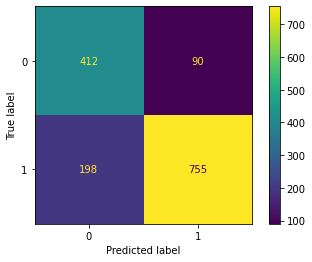

In [72]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm1)
disp.plot();

In [73]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 412
False Positives: 90
False Negatives: 198
True Positives: 755


In [74]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('f1 score: {}' . format(round(f1_score(y_test, preds1),4)))

Accuracy: 0.8021
Misclassification rate: 0.1979
Precision: 0.8935
Recall: 0.7922
Specificity: 0.8207
f1 score: 0.8398


#### Naive Bayes Multinomial + TF-IDF

In [75]:
# Naive Bayes Model 2
nb = MultinomialNB()
tvec = TfidfVectorizer(stop_words = sw_spacy)

#Setting up the pipeline
pipe = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])
#hyperparameters:
params = {
    'tvec__max_features': [ 1_000, 2_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,2),(1,3)],
    'nb__alpha': [0.1, 0.2], 
}
gs2 = GridSearchCV(pipe, 
                  param_grid=params, 
                  cv=5)
# Fit GridSearch to training data.
gs2.fit(X_train, y_train)
print("Best params: {}".format(gs2.best_params_))
print('Number of features: {}'.format(len(gs2.best_estimator_.named_steps.tvec.get_feature_names())))
print('Train score : {},  Best score: {}, Test score: {}'.format(round(gs2.score(X_train,y_train),4),
                                                                 round(gs2.best_score_, 4),
                                                                 round(gs2.best_estimator_.score(X_test, y_test), 4)))


Best params: {'nb__alpha': 0.1, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Number of features: 2000
Train score : 0.866,  Best score: 0.8121, Test score: 0.8103


In [76]:
# Get predictions
preds2 = gs2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()
cm2 = confusion_matrix(y_test, preds2)

##### The Confusion Matrix Plot

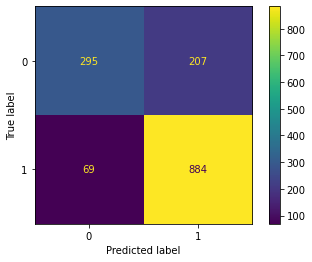

In [77]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm2)
disp.plot();

In [78]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 295
False Positives: 207
False Negatives: 69
True Positives: 884


In [79]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('f1 score: {}' . format(round(f1_score(y_test, preds2),4)))

Accuracy: 0.8103
Misclassification rate: 0.1897
Precision: 0.8103
Recall: 0.9276
Specificity: 0.5876
f1 score: 0.865


### Logistic Regression Model

#### Logistic Regression + TF-IDF

In [80]:
lr = LogisticRegression(max_iter=2000)
tvec =  TfidfVectorizer(stop_words = sw_spacy)

pipe = Pipeline([
    ('tvec', tvec),
    ('lr', lr)
])
#hyperparameters:
params = {
    'tvec__max_features': [ 2_000, 3_000, 4_000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1),(1,2)],
    'lr__C' : [1,10,100]
}
gs5 = GridSearchCV(pipe, 
                  param_grid=params, 
                  cv=5)
# Fit GridSearch to training data.
gs5.fit(X_train, y_train)
print("Best params: {}".format(gs5.best_params_))
print('Number of features: {}'.format(len(gs5.best_estimator_.named_steps.tvec.get_feature_names())))
print('Train score : {},  Best score: {}, Test score: {}'.format(round(gs5.score(X_train,y_train),4),
                                                                 round(gs5.best_score_, 4),
                                                                 round(gs5.best_estimator_.score(X_test, y_test), 4)))


Best params: {'lr__C': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Number of features: 2000
Train score : 0.9708,  Best score: 0.8571, Test score: 0.8467


##### Features Coefficient

In [81]:
lr = LogisticRegression(max_iter=2000,
                        C = 10,
                       )
cvec =  TfidfVectorizer(stop_words= sw_spacy,
                       max_df = 0.9,
                       max_features = 3000,
                       min_df = 1,
                       ngram_range = (1,2))
pipe = Pipeline([
    ('tvec', tvec),
    ('lr', lr)
]) 

pipe.fit(X_train, y_train);
lr_feat2 = pd.DataFrame(data=lr.coef_.T, index=tvec.get_feature_names())
lr_feat2.columns = ['coef_']
lr_feat2['abs_coef'] = np.exp(lr_feat2['coef_'])
lr_feat2.sort_values(by='abs_coef', ascending=False).head(30)

,coef_,abs_coef
bitcoins,4.351584,77.601258
stacking,3.316360,27.559839
lightning,3.265969,26.205480
sat,3.163057,23.642756
thank,3.098838,22.172174
bitcoiners,2.868879,17.617261
buy,2.799385,16.434542
earning,2.794342,16.351858
panic,2.728826,15.314899
self,2.711645,15.054012


In [82]:
# Get predictions
preds5 = gs5.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds5).ravel()
cm5 = confusion_matrix(y_test, preds5)

##### The Confusion Matrix Plot

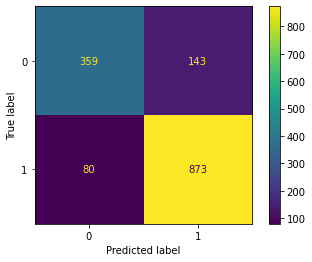

In [83]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm5)
disp.plot();

In [84]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 359
False Positives: 143
False Negatives: 80
True Positives: 873


In [85]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, preds5).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('f1 score: {}' . format(round(f1_score(y_test, preds5),4)))

Accuracy: 0.8467
Misclassification rate: 0.1533
Precision: 0.8593
Recall: 0.9161
Specificity: 0.7151
f1 score: 0.8867


#### Logistic Regression + CountVectorizer

In [86]:
lr = LogisticRegression(max_iter=2000)
cvec =  CountVectorizer(stop_words= sw_spacy)

pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
])
#hyperparameters:
params = {
    'cvec__max_features': [1_000, 2_000, 3_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__C' : [0.1,1.0,10],
}
gs = GridSearchCV(pipe, 
                  param_grid=params, 
                  cv=5)
# Fit GridSearch to training data.
gs.fit(X_train, y_train)
print("Best params: {}".format(gs.best_params_))
print('Train score : {},Best score: {},Test score: {}'.format(round(gs.score(X_train,y_train),4),
                                                              round(gs.best_score_, 4),
                                                              round(gs.best_estimator_.score(X_test, y_test), 4)))
print('Number of features: {}'.format(len(gs.best_estimator_.named_steps.cvec.get_feature_names())))

Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0}
Train score : 0.9971,Best score: 0.863,Test score: 0.844
Number of features: 3000


##### Features Coefficient

In [87]:
lr = LogisticRegression(max_iter=2000,
                        C = 1.0,
                       )
cvec =  CountVectorizer(stop_words= sw_spacy,
                       max_df = 0.9,
                       max_features = 3000,
                       min_df = 3,
                       ngram_range = (1,2))
pipe = Pipeline([
    ('cvec', cvec),
    ('lr', lr)
]) 

pipe.fit(X_train, y_train);
lr_feat = pd.DataFrame(data=lr.coef_.T, index=cvec.get_feature_names())
lr_feat.columns = ['coef_']
lr_feat['abs_coef'] = np.exp(lr_feat['coef_'])
lr_feat.sort_values(by='abs_coef', ascending=False).head(30)

,coef_,abs_coef
valuable,1.133496,3.106498
panic,1.035556,2.816672
bitcoiners,0.982250,2.670459
bitcoins,0.971190,2.641086
monetary,0.939852,2.559602
worried,0.933420,2.543192
standard,0.926676,2.526098
response,0.911055,2.486945
node,0.907059,2.477027
altcoins,0.902695,2.466242


##### The Confusion Matrix Plot

In [88]:
# Get predictions
preds6 = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds6).ravel()
cm6 = confusion_matrix(y_test, preds6)

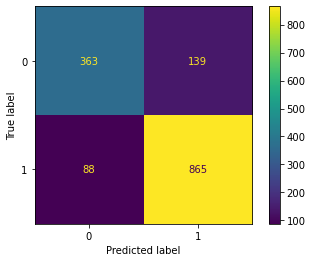

In [89]:
# View confusion matrix

disp = ConfusionMatrixDisplay(cm6)
disp.plot();

In [90]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 363
False Positives: 139
False Negatives: 88
True Positives: 865


In [91]:
# Examine some classification metrics 
tn, fp, fn, tp = confusion_matrix(y_test, preds6).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('f1 score: {}' . format(round(f1_score(y_test, preds6),4)))

Accuracy: 0.844
Misclassification rate: 0.156
Precision: 0.8616
Recall: 0.9077
Specificity: 0.7231
f1 score: 0.884


## Conclusion and Recommendations
---
|#| Vectorizer | Model | Best Score | Train Score | Test Score (Accuracy) | FN|
|---|---|---|---|---|---|---|
|1|CountVectorizer|Multinomial Naïve Bayes|0.7994|0.8392|0.8021|0.8398|
|2|TfidfVectorizer|Multinomial Naïve Bayes|0.8296|0.8842|0.8296|0.9089|
|3|CountVectorizer|Logistic Regression|0.8845|0.9973|0.877|0.9089|
|4|TfidfVectorizer|Logistic Regression|0.8837|0.9838|0.8735|0.906|

**Model Selection: Logistic Regression with CountVectorizer** as it has the best accuracy and f1 scoring

All the models here outperformed the baseline accuracy score of 0.654. As the focus is on getting as many correct prediction as possible. The Logistic Regression with CountVectorizer has the best predictive performance on the classification problem. On top of that, it has a relatively low False Negative (Type II error) whereby we predicted that post to be cryptocurrency, but in fact, the post is relating to bitcoin. Hence, we would have to look at the Sensitivity (TP/(TP+FN)), the lower the FN, the higher the Sensitivity. Through the research, we were able to address some other problems such identifying many common words at appear in both post, and strong coefficent features. We could further apply it into the system a the first validation for system to pass thur as related posting for create a expectional listing that need further human intervention. 

Moving forward, we could potentially include more other relevant modelling such as random forest, Knn or decision tree to further analysis is there even better modelling for this dectection to minimise the need for human intervention. In addition, image posts were not taken into account, this could be tapped on given that our current generation usually prefers to post memes instead. Lastly, a more detailed study on the True Negative (TN) would also provide insights for us to see how can we use that to improve the predictions.